In [1]:
import gym
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [81]:
# define a neural network class
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(4, 128,bias=True)
        self.fc1 = nn.Linear(128, 2,bias=True)
        self.fc2 = nn.Softmax(dim=0)
        
        self.apply(self.init_weights)

        for param in self.parameters():
            param.requires_grad = False    
 
    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def init_weights(self,m):
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.00)

net = Net()
print(net)

Net(
  (fc0): Linear(in_features=4, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
  (fc2): Softmax(dim=0)
)


## Genetic Algorithm optimization: design and initialization

In [82]:
#disable gradients as we will not use them
torch.set_grad_enabled(False)

In [83]:
def generate_population(n=100):
    
    population = np.r_[n*[Net()]]
    
    return population

In [84]:
# initial population
population_init = generate_population()

In [87]:
# have the NN in your population play the Cartpole game
def play_population(population, how_many_games=10, verbose=True, score_stop=1e4, deterministic_player=False):
    
    population_score = []
    n_player = len(population)
    
    if verbose:
        print("playing: ", end =" ")
    
    for j, player in enumerate(population):
        
        player_score = []
        
        for k in range(how_many_games):
            # load the environment to play the CartPole game
            env = gym.make('CartPole-v0')
            observation = env.reset()
            env._max_episode_steps = score_stop
            score = 0
            done = False
            i = 0
            
            while not done and i<score_stop:

                input_info = torch.Tensor(observation)
                ouput = player(input_info)
                if deterministic_player:
                    observation, reward, done, info = env.step(ouput.numpy().argmax())
                else:
                    observation, reward, done, info = env.step(np.random.choice([0,1], 1, p=ouput.numpy())[0])

                score += reward
                i += 1

            player_score.append(score)
            
        population_score.append(np.min(player_score))
        
        if np.logical_and(verbose, np.mod(j, int(n_player/10))==0):
            print(np.rint(100*j/n_player),"%|", end =" ")
    
    if verbose:
        print(100,"%")
        
    return np.r_[population_score]

In [88]:
# Select the most fit players
def darwin(population, population_score, q=0.9):

    index_selection = population_score.argsort()
    selected = int(np.rint((1.0-q)*len(population)))
    
    return population[index_selection[-selected:]]

In [89]:
# Generate children hybrid from your fittest population (all of that sounds horrible...)
def hybrid(
    population, 
    mutation_level_floor=0.1, mutation_level_relative_std=0.1, 
    n_descendants=9, verbose=True, 
):
    
    # keep the original parents for reference
    new_population = copy.deepcopy(population).tolist()
    n_player = len(population)
    
    for j, parent in enumerate(population):
        
        for i in range(n_descendants):
            children = copy.deepcopy(parent)
            
            state_dict = children.state_dict()

            for name, prm in state_dict.items():
                mutation_std = np.sqrt((prm*mutation_level_relative_std)**2 + mutation_level_floor**2)
                aux = prm + mutation_std * np.random.randn(*prm.shape)
                state_dict[name].copy_(aux)
            
            new_population.append(children)
        
    if verbose:
        print("new population size: ", len(new_population))
    
    return np.r_[new_population]

## They Evolve!

In [90]:
# make your initial population goes through several cycles of natural selection and hybridation (still sounds terrible)
def evolve(
    n_player=500, n_generation=100,
    verbose_evolve=True, plot_it=False,
    kwargs_play={}, kwargs_darwin={}, kwargs_hybrid={}
):
    if 'score_stop' in kwargs_play.keys():
        max_achievable_score = kwargs_play['score_stop']
    else:
        max_achievable_score = 1e4
        kwargs_play['score_stop'] = 1e4
        
    if 'q' in kwargs_darwin.keys():
        percentile = 100. * kwargs_darwin['q']
    else:
        percentile = 90

    population = generate_population(n_player)
    max_score = 0.
    percentile_score = 0.
    evolution_max_score = []
    evolution_percentile_score = []
    i_gen = 0
    
    while i_gen<n_generation and percentile_score < max_achievable_score:
        
        population_score = play_population(population, **kwargs_play)
        winners = darwin(population, population_score, **kwargs_darwin)
        population = hybrid(winners, **kwargs_hybrid)
        max_score = population_score.max()
        percentile_score = np.percentile(population_score, percentile)
        evolution_max_score.append(max_score)
        evolution_percentile_score.append(percentile_score)
    
        if verbose_evolve:
            print(
                "Generation {}:\nMaximum score achieved: ".format(i_gen), max_score,
                "\npercentile {}% score achieved: ".format(percentile), percentile_score,
            )
        
        if plot_it:
            fig, ax = plt.subplots(1,1,figsize=(5,5))
            ax.hist(population_score, density=True,bins=10)
            ax.set_xlabel("score")

            plt.show()
            
        i_gen += 1
    
    best_player = darwin(population, population_score, **kwargs_darwin) #q=1.-1./len(population))
    
    return best_player, evolution_max_score, evolution_percentile_score

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 0:
Maximum score achieved:  21.0 
percentile 90.0% score achieved:  16.0


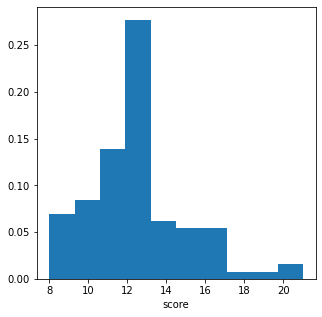

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 1:
Maximum score achieved:  27.0 
percentile 90.0% score achieved:  16.0


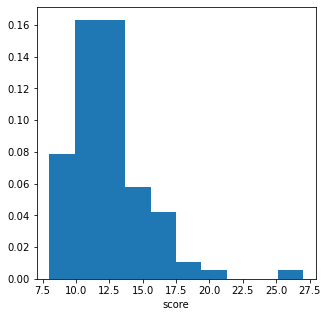

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 2:
Maximum score achieved:  25.0 
percentile 90.0% score achieved:  16.0


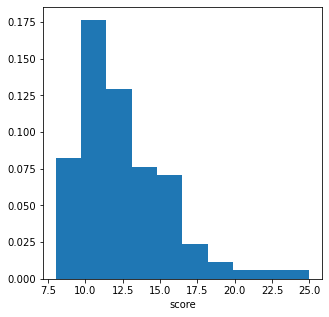

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 3:
Maximum score achieved:  24.0 
percentile 90.0% score achieved:  18.0


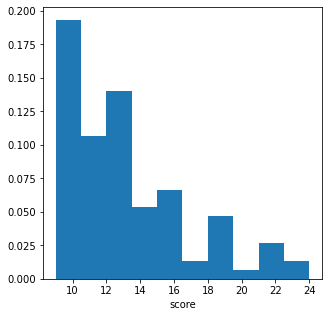

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 4:
Maximum score achieved:  45.0 
percentile 90.0% score achieved:  19.0


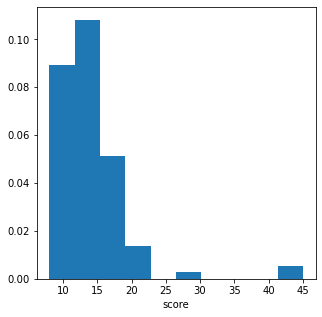

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 5:
Maximum score achieved:  31.0 
percentile 90.0% score achieved:  24.0


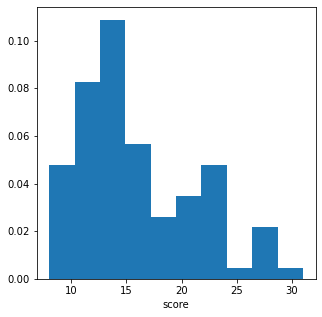

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 6:
Maximum score achieved:  48.0 
percentile 90.0% score achieved:  25.0


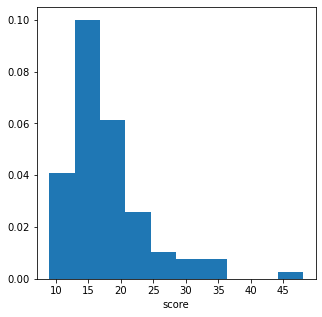

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 7:
Maximum score achieved:  50.0 
percentile 90.0% score achieved:  34.0


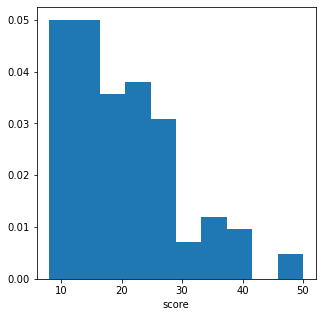

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 8:
Maximum score achieved:  71.0 
percentile 90.0% score achieved:  33.10000000000001


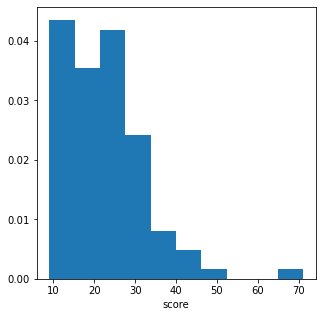

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 9:
Maximum score achieved:  109.0 
percentile 90.0% score achieved:  44.10000000000001


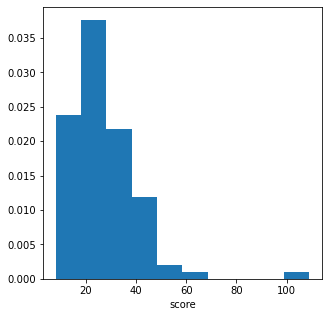

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 10:
Maximum score achieved:  64.0 
percentile 90.0% score achieved:  45.10000000000001


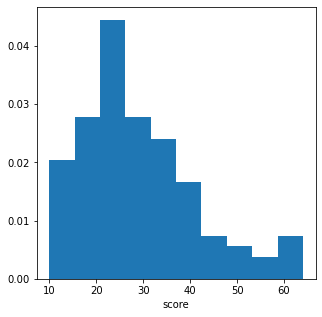

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 11:
Maximum score achieved:  127.0 
percentile 90.0% score achieved:  56.60000000000005


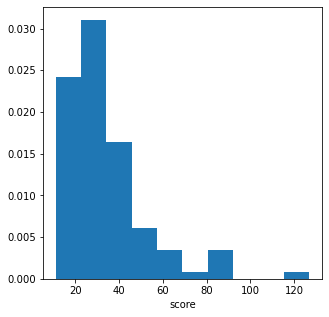

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 12:
Maximum score achieved:  117.0 
percentile 90.0% score achieved:  83.20000000000002


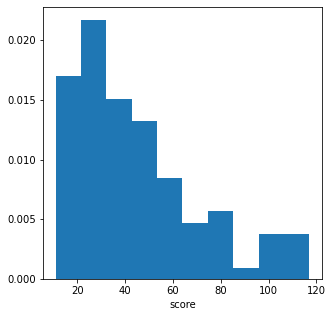

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 13:
Maximum score achieved:  164.0 
percentile 90.0% score achieved:  109.30000000000003


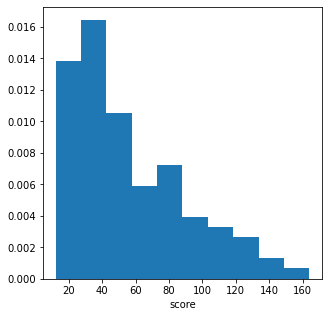

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 14:
Maximum score achieved:  204.0 
percentile 90.0% score achieved:  121.30000000000003


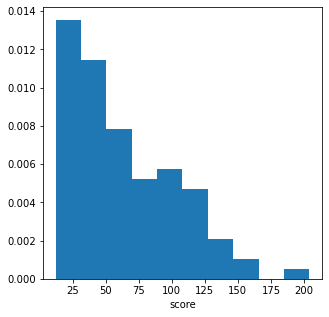

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 15:
Maximum score achieved:  193.0 
percentile 90.0% score achieved:  135.40000000000003


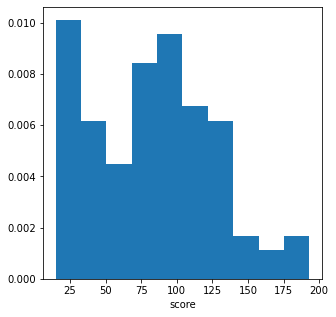

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 16:
Maximum score achieved:  262.0 
percentile 90.0% score achieved:  172.50000000000006


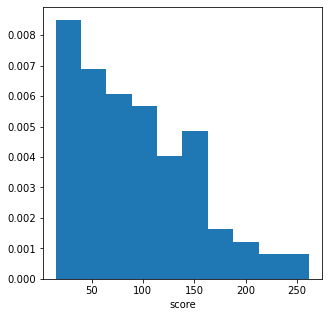

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 17:
Maximum score achieved:  370.0 
percentile 90.0% score achieved:  156.80000000000015


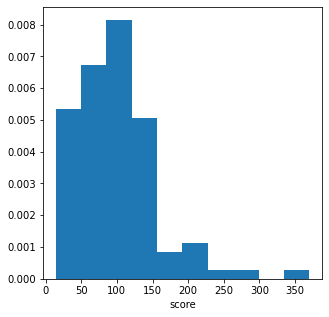

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 18:
Maximum score achieved:  463.0 
percentile 90.0% score achieved:  217.5000000000001


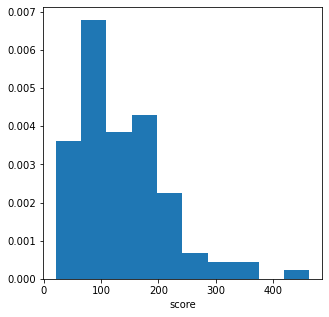

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 19:
Maximum score achieved:  500.0 
percentile 90.0% score achieved:  256.1000000000001


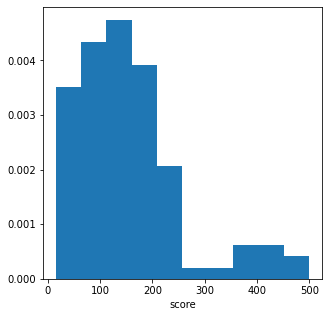

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 20:
Maximum score achieved:  1000.0 
percentile 90.0% score achieved:  364.3000000000001


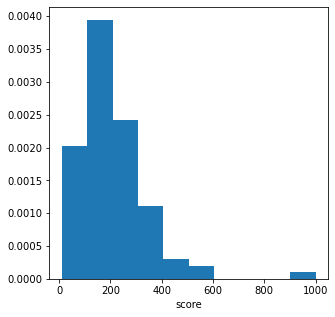

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 21:
Maximum score achieved:  778.0 
percentile 90.0% score achieved:  409.1


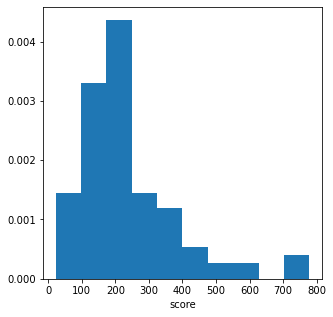

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 22:
Maximum score achieved:  1000.0 
percentile 90.0% score achieved:  485.80000000000007


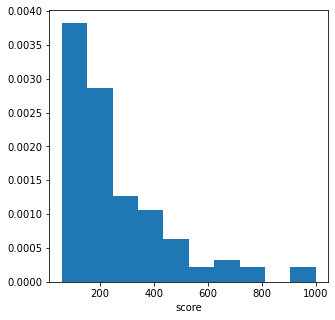

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 23:
Maximum score achieved:  1000.0 
percentile 90.0% score achieved:  617.4000000000003


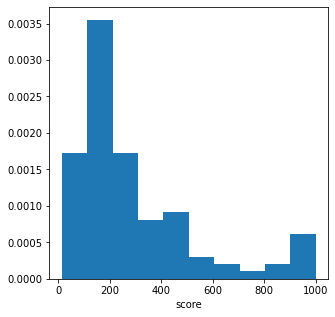

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 24:
Maximum score achieved:  1000.0 
percentile 90.0% score achieved:  860.3000000000004


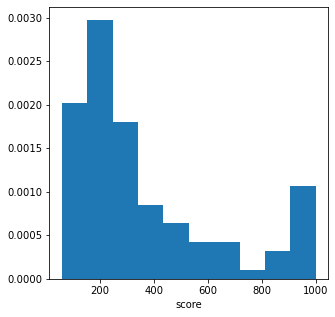

playing:  0.0 %| 10.0 %| 20.0 %| 30.0 %| 40.0 %| 50.0 %| 60.0 %| 70.0 %| 80.0 %| 90.0 %| 100 %
new population size:  100
Generation 25:
Maximum score achieved:  1000.0 
percentile 90.0% score achieved:  1000.0


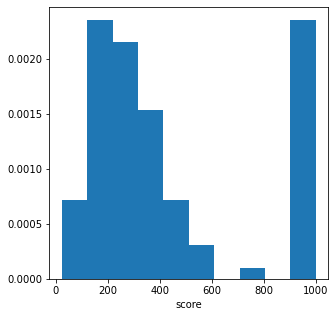

In [92]:
# Let's Rumble!
champion, evolution_curves_max_score, evolution_curves_percentile_score = evolve(
    n_player=100,
    n_generation=100,
    plot_it=True,
    kwargs_play={"how_many_games":5,"deterministic_player":False,'score_stop':1e3},
    kwargs_darwin={"q":0.9,},
    kwargs_hybrid={
        "mutation_level_floor":0.1, "mutation_level_relative_std":0.1,
        "n_descendants":9, "verbose":True,
    }
)

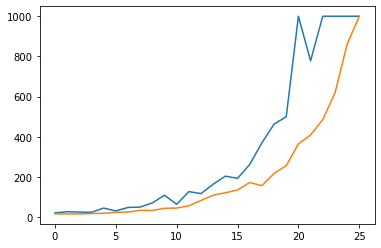

In [93]:
plt.plot(evolution_curves_max_score)
plt.plot(evolution_curves_percentile_score)

In [95]:
# let's visualize the best players
env = gym.make('CartPole-v0')
env._max_episode_steps = 1000
for player in champion:
    observation = env.reset()
    for t in range(20000):
        env.render()
        input_info = torch.Tensor(observation)
        ouput = player(input_info)
        observation, reward, done, info = env.step(ouput.numpy().argmax())
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 375 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
Episode finished after 1000 timesteps
